In [1]:
# Import semua packages 
import pandas as pd            # Untuk baca CSV
import json                    # Untuk parse JSON
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Polygon
from PIL import Image
from io import BytesIO
import requests                 # Untuk load image dari URL

# 2. Load CSV file
csv_file_path = "csv_to_convert.csv"
annotation_csv = pd.read_csv(csv_file_path)
print("CSV file loaded. Number of rows:", len(annotation_csv))


CSV file loaded. Number of rows: 6


In [2]:
# 3. Parse JSON annotation data
#    Column 'image_annotation_data' ada string JSON untuk setiap image
annotation_csv['annotations_parsed'] = annotation_csv['image_annotation_data'].apply(json.loads)
print("JSON annotations parsed for each row.")

# 4. Siapkan structure COCO dataset
coco_dataset = {
    "images": [],        # Semua info image
    "annotations": [],   # Semua info annotation (rectangle/polygon)
    "categories": []     # Semua label kategori
}



JSON annotations parsed for each row.


In [3]:
# 5. Untuk assign ID kategori dan annotation
label_to_category_id = {}      # Map nama label → category_id
next_category_id = 1
next_annotation_id = 1

# 6. Loop setiap row dalam CSV
for index, row in annotation_csv.iterrows():
#tambah info gambar ke format coco
    image_info = {
        "id": row['id'],                      # Unique ID untuk image
        "file_name": row['image_annotation_url'],  # URL atau path image
        "height": 0,                           # Boleh isi kalau ada info height
        "width": 0                             # Boleh isi kalau ada info width
    }
    coco_dataset['images'].append(image_info)
    
#Process setiap annotation dalam image
    annotations_for_this_image = row['annotations_parsed']
    
    for annotation in annotations_for_this_image:
        label_name = annotation['options']['label']
        
# Kalau label baru kena assign category ID baru
        if label_name not in label_to_category_id:
            label_to_category_id[label_name] = next_category_id
            coco_dataset['categories'].append({
                "id": next_category_id,
                "name": label_name
            })
            next_category_id += 1
        
        points = annotation['points']
        
#Check shape: Polygon atau Rectangle
        if isinstance(points[0], list):
# Polygon
            polygon_points = points[0]
            x_coords = [p['x'] for p in polygon_points]
            y_coords = [p['y'] for p in polygon_points]
            x_min, y_min = min(x_coords), min(y_coords)
            x_max, y_max = max(x_coords), max(y_coords)
            
# Flatten points for segmentation according to coco format
            segmentation = [[coord for p in polygon_points for coord in (p['x'], p['y'])]]
        else:
# Rectangle
            x_min, y_min = points[0]['x'], points[0]['y']
            x_max, y_max = points[1]['x'], points[1]['y']
            segmentation = None

#Buat bounding box [x_min, y_min, width, height]

        bbox = [x_min, y_min, x_max - x_min, y_max - y_min]
        
#Masukkan annotation ke COCO

        coco_dataset['annotations'].append({
            "id": next_annotation_id,
            "image_id": row['id'],
            "category_id": label_to_category_id[label_name],
            "bbox": bbox,
            "area": bbox[2]*bbox[3],
            "iscrowd": 0,
            "segmentation": segmentation
        })
        next_annotation_id += 1

print("All images and annotations converted to COCO format.")



All images and annotations converted to COCO format.


In [4]:
# 7. Simpan COCO dataset ke JSON
output_json_file = "coco_format.json"
with open(output_json_file, "w") as cocoFormat:
    json.dump(coco_dataset, cocoFormat, indent=4)
print(f"COCO dataset saved to {output_json_file}")



COCO dataset saved to coco_format.json


In [5]:
# 8. Validation

validation_issues = []

# Check images without annotations
for img in coco_dataset['images']:
    annotations_for_img = [ann for ann in coco_dataset['annotations'] if ann['image_id'] == img['id']]
    if len(annotations_for_img) == 0:
        validation_issues.append(f"Image ID {img['id']} has no annotations.")

# Check for duplicate image IDs
image_ids = [img['id'] for img in coco_dataset['images']]
duplicate_image_ids = set([x for x in image_ids if image_ids.count(x) > 1])
if duplicate_image_ids:
    validation_issues.append(f"Duplicate image IDs found: {list(duplicate_image_ids)}")

# Check missing metadata (file_name, height, width)
for img in coco_dataset['images']:
    if not img.get('file_name'):
        validation_issues.append(f"Image ID {img['id']} missing file_name")
    if img.get('height', 0) == 0 or img.get('width', 0) == 0:
        validation_issues.append(f"Image ID {img['id']} missing height/width")

# Check category ID mismatch in annotations
valid_category_ids = [cat['id'] for cat in coco_dataset['categories']]
for ann in coco_dataset['annotations']:
    if ann['category_id'] not in valid_category_ids:
        validation_issues.append(f"Annotation ID {ann['id']} has invalid category_id {ann['category_id']}")

# Save validation report
validation_file = "validation_report.json"
if validation_issues:
    report_content = {"issues": validation_issues}
else:
    report_content = {"issues": ["No issues found"]}

with open(validation_file, "w") as validation:
    json.dump(report_content, validation, indent=4)

print(f"Validation completed. Report saved to {validation_file}")


Validation completed. Report saved to validation_report.json


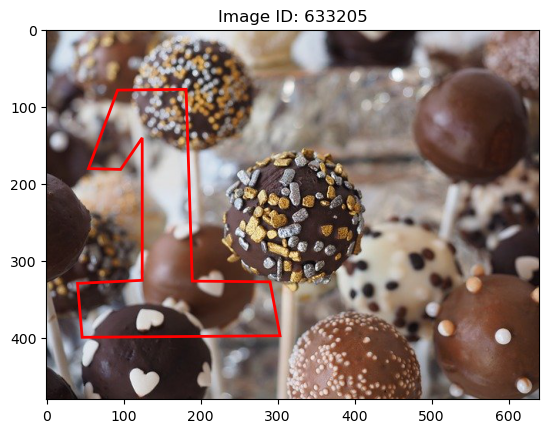

In [6]:
# 9. Function untuk visualize annotations
def visualize_image_annotations(row_image):

# Load image dari URL
    image_url = row_image['image_annotation_url']
    image_obj = Image.open(BytesIO(requests.get(image_url).content))
    
# Buat figure
    plt.imshow(image_obj)
    plt.title(f"Image ID: {row_image['id']}")
    
# Ambil semua annotation untuk image ni
    annotations_for_image = [img1 for img1 in coco_dataset['annotations'] if img1['image_id'] == row_image['id']]
    
    for ann in annotations_for_image:
        color = "red"
        if ann['segmentation']:
            poly_coords = ann['segmentation'][0]
            xy = [(poly_coords[i], poly_coords[i+1]) for i in range(0, len(poly_coords), 2)]
            plt.gca().add_patch(Polygon(xy, closed=True, fill=False, edgecolor=color, linewidth=2))
        else:
            x, y, w, h = ann['bbox']
            plt.gca().add_patch(Rectangle((x, y), w, h, fill=False, edgecolor=color, linewidth=2))
    
    plt.show()

#display the first image
visualize_image_annotations(annotation_csv.iloc[0])


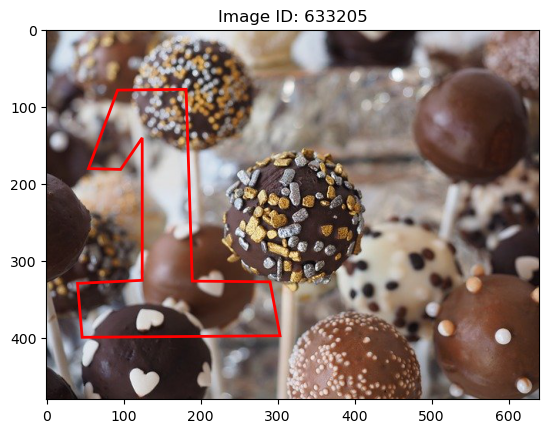

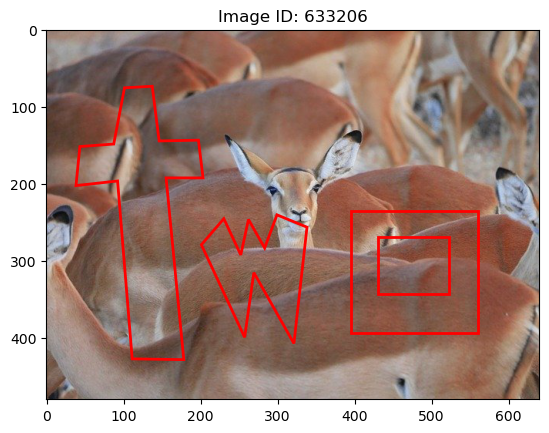

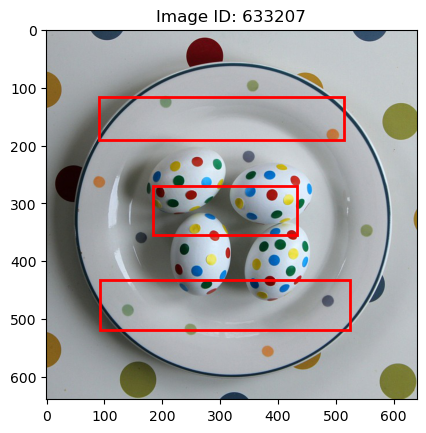

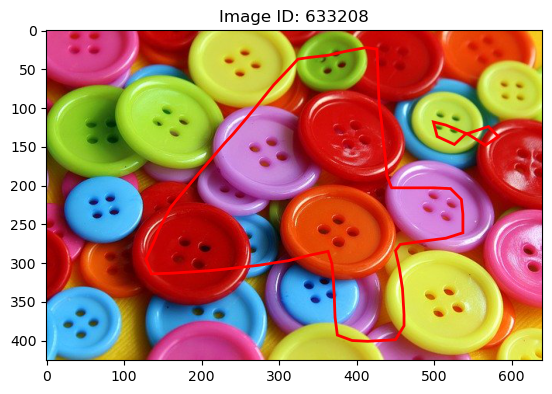

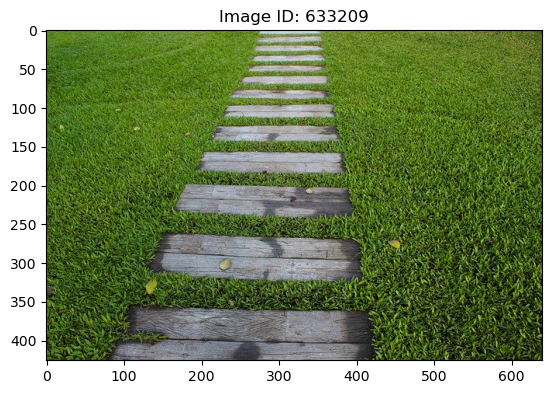

In [7]:
#multiple images
for i in range(5):
    visualize_image_annotations(annotation_csv.iloc[i])